In [80]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.datasets import make_moons

In [81]:
def kernel(X1, X2, scale=1.0, sigma_f=1.0): #Generates a kernel
    ''' Uncomment for Gaussian Kernel '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp((-0.5 / scale**2) * sqdist)
#    ''' Uncomment for Linear Kernel '''
#    return X1 @ X2.T

In [82]:
def dataSet2(): #Generates dataset
    X, y = make_moons(n_samples=100, noise=0.1) #X is a 100x2 set of points, y is (100,) array of classification values. 0 for below X-axis, 1 for above
    y = np.where(y==0, -1, y)      #Makes the 0 values to -1
    y = y.reshape(-1,1)            #Reshapes it for ez processing
    S = (y>0).squeeze()            #S contains boolean values
    x_pos = X[S]                   #Contains all positive X values
    x_neg = X[np.invert(S)]        #Constains all negative X values
    return X,y,x_pos,x_neg         

In [91]:
def dualOptimizer(H,m,y):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H) #Converts H into a cvxopt matrix with e-notation
    q = cvxopt_matrix(-np.ones((m, 1))) #mx1 matrix having -1
    G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
    h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * 69)))
#     G = cvxopt_matrix(-np.eye(m))  #mxm identity matrix with value -1 instead of 1
#     h = cvxopt_matrix(0.05*np.ones(m)) #mx1 array of C values. Here 0.1
    A = cvxopt_matrix(y.reshape(1, -1))  #just the y array reshaped as (1,100)
    b = cvxopt_matrix(np.zeros(1)) #one zero value but in cvxopt form
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    '''
    Solves a quadratic program

    minimize    (1/2)*x'*P*x + q'*x
    subject to  G*x <= h
                A*x = b.
                
    if h and b are 0's it is effectively having no slack.
    thus changing them to some constant value (<1) would be implementation of slack and thus soft margins
'''
    sol = cvxopt_solvers.qp(P, q, G, h, A, b) #is the default output of the solvers, refer documentation for more info
    alphas = np.array(sol['x']) # is the alpha values (lambda values for the lagrange multipliers)
    return alphas

In [92]:
def pred(y,a,X,p,b): #predicts p value using kernel trick
    k = kernel(X,p)
    return (y * a).T @ k +b 
    
def predb(y,a,X,p):    #predicts b value using kernel trick
    k = kernel(X,p)
    xc = (y * a).T @ k
    print(k.shape,xc.shape)
    return np.average(y.T-xc)

In [93]:
np.random.seed(69)
X,y,x_pos,x_neg = dataSet2()
k = kernel(X,X)
t = np.dot(y,y.T)
H = k*t              
m,n = X.shape

alphas = dualOptimizer(H,m,y)

#Selecting the set of indices S corresponding to non zero parameters
S = (alphas > 1e-4).flatten()

w = ((y[S] * alphas[S]).T @ X[S]).reshape(-1,1)

#Computing b
b = predb(y[S],alphas[S],X[S],X[S])

#Display results
print('Alphas: ',alphas,'\n Support Vectors: ',S.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas[alphas > 1e-4])
print('w = ', w.flatten())
print('b = ', b)


(7, 7) (1, 7)
Alphas:  [[1.70068166e-12]
 [1.23404503e-12]
 [1.83312694e-12]
 [9.47809903e-13]
 [4.40843327e-13]
 [1.76883004e-12]
 [1.32170964e-12]
 [5.67683139e-13]
 [1.02679937e-12]
 [9.40279145e-13]
 [5.77618475e-13]
 [6.91752225e-13]
 [7.83357053e-13]
 [2.16162064e-12]
 [4.95604205e-12]
 [5.71181998e-13]
 [7.18621023e-13]
 [6.91232535e-13]
 [1.28029469e-12]
 [1.07323511e-12]
 [8.14302656e-13]
 [8.12593781e-13]
 [6.20226086e-12]
 [5.40004400e-13]
 [8.15159474e-13]
 [8.02218224e-13]
 [1.38474934e-12]
 [6.85330925e+00]
 [5.40368352e-13]
 [5.78499304e-13]
 [1.37007471e-12]
 [6.26261815e-13]
 [3.60381795e-12]
 [1.06779295e-12]
 [2.04071027e-12]
 [9.70154171e-12]
 [6.03355505e+01]
 [6.58214095e-13]
 [1.06731059e-12]
 [1.13759548e-12]
 [1.17479946e-12]
 [1.22192358e-12]
 [6.33731477e-13]
 [6.51673583e-13]
 [6.03882865e-13]
 [8.89550336e-13]
 [7.16044404e-12]
 [6.59571149e-13]
 [1.93700846e-11]
 [1.88765796e-12]
 [2.28711812e-12]
 [5.53627398e-13]
 [1.21313074e-12]
 [1.89945668e-12]
 [1.0

<a list of 3 text.Text objects>

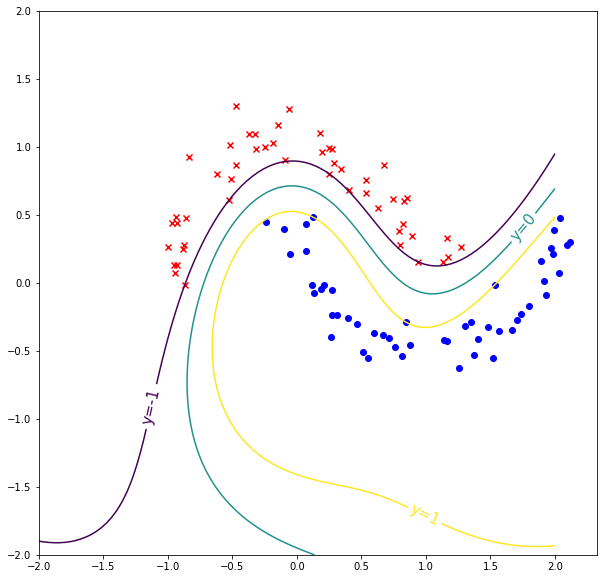

In [94]:
fig = plt.figure(figsize = (10,10))

'''Prediction for p matrix '''
x0, x1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p = np.array([x0, x1]).reshape(2, -1).T
pr = pred(y[S],alphas[S],X[S],p,b)
#print(pr)


'''margin hyperplanes'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp = plt.contour(x0, x1, pred(y[S],alphas[S],X[S],p,b).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp, fmt='y=%.f', inline=True, fontsize=15)

In [30]:
cvxopt_solvers?